# Lanedetection from Driveable Area Segmentation
## First approache
### Setup

In [ ]:
%%capture
! wget "https://arcxyon.com/wp-content/uploads/2025/08/Raw_Examples_04-08-2025.zip"
! unzip "Raw_Examples_04-08-2025.zip"

In [ ]:
example_img_path = "67/"

In [ ]:
%%capture
! pip install ultralytics

In [ ]:
%%capture
! wget "https://arcxyon.com/wp-content/uploads/2025/08/yolo-seg-m_best_epochs-100_size-460-960_05-08-2025.zip"
! unzip "yolo-seg-m_best_epochs-100_size-460-960_05-08-2025.zip"

In [ ]:
from ultralytics import YOLO
model = YOLO("yolo-seg-m_best_epochs-100_size-460-960_05-08-2025/yolo-seg-m_best_epochs-100_size-460-960_05-08-2025.pt")

In [ ]:
from PIL import Image
import os
import random
import cv2

def get_random_cv2_img(path, only_path=False):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    random_sample = random.choice(files)
    if only_path:
        return random_sample
    else:
        return cv2.imread(os.path.join(path, random_sample))

In [ ]:
import matplotlib.pyplot as plt

def show(img, cv2_img = True):
    if cv2_img: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 10)) # img display size
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
import numpy as np

def process_image(img): 
    # Step 1: Conditional CLAHE
    # extract luminance channel
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    luminance = img_yuv[:, :, 0]
    avg_brightness = np.mean(luminance)

    if avg_brightness < 50:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:
        img_clahe = img.copy()

    # Step 2: Gamma Correction
    lut = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        # normalize pixel value to [0, 1]
        normalized = i / 255.0
        # adaptive gamma factor (current maximum: 1.5)
        gamma = 1.0 + (1.5 - 1.0) * (1 - normalized)  # gamma decreases with brightness
        corrected = pow(normalized, 1.0 / gamma)
        lut[i] = np.clip(corrected * 255, 0, 255)
    img_bright = cv2.LUT(img, lut)


    # Step 3: Unsharp Masking
    blurred = cv2.GaussianBlur(img_bright, (0, 0), sigmaX=2)
    amount = 1.5
    return cv2.addWeighted(img_bright, 1 + amount, blurred, -amount, 0)

In [ ]:
def get_lane_segmentation(img):
    copied_img = img.copy()
    
    # use model.predict on specific device when having multiple gpus
    results = model.predict(copied_img, device='cpu', batch=1)
    
    overlay = copied_img.copy()
    
    # get results (assuming single image per call)
    for result in results:
        if result.masks:
            for polygon in result.masks.xy:
                pts = polygon.astype(int).reshape((-1, 1, 2))
                cv2.fillPoly(overlay, [pts], color=(0, 0, 255))  # Red filled mask
    
    # blend overlay with original image (alpha blending)
    alpha = 0.4  # transparency factor (0 = fully transparent, 1 = fully opaque)
    cv2.addWeighted(overlay, alpha, copied_img, 1 - alpha, 0, dst=copied_img)

    return copied_img, pts

In [ ]:
img_name = get_random_cv2_img(example_img_path, True)
img_path = os.path.join(example_img_path, img_name)
img = cv2.imread(img_path)

segmented_img, pts = get_lane_segmentation(img) 

show(segmented_img, cv2_img=True)

### Extract Lanes

In [ ]:
def extract_area(img, pts):
    # Step 1: Create a black mask same size as image
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    # Step 2: Fill the polygon on the mask
    cv2.fillPoly(mask, [pts], 255)
    # Step 3: Bitwise-and to extract the region
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    return masked_image

In [ ]:
roi = extract_area(img, pts)
show(roi, cv2_img=True)

Optional: Morphological operations to clean noise was not a good approche. 

In [ ]:
def extract_markers(img):
    copied_img = img.copy()
    
    # 1. Convert to HSV for better color filtering
    hsv = cv2.cvtColor(copied_img, cv2.COLOR_BGR2HSV)

    # 2. Define white color range in HSV
    # White has low saturation and high value
    # H: (0–180 in OpenCV)
    lower_white = np.array([0, 0, 150])
    upper_white = np.array([180, 60, 255])

    # 3. Create mask
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    # 4. Bitwise-and to extract white parts
    lanes = cv2.bitwise_and(copied_img, copied_img, mask=white_mask)

    return lanes, white_mask

In [ ]:
lanes, mask = extract_markers(roi)
show(lanes, cv2_img=True)
show(mask)

In [ ]:
gray = cv2.cvtColor(lanes, cv2.COLOR_BGR2GRAY)

# Apply histogram equalization
equalized = cv2.equalizeHist(gray)

show(equalized)

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

show(enhanced)

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))  # tune size
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)

show(tophat)

In [ ]:
min_val = np.min(gray)
max_val = np.max(gray)
stretched = ((gray - min_val) / (max_val - min_val) * 255).astype(np.uint8)

show(roi)
show(stretched)

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
morph = cv2.morphologyEx(lanes, cv2.MORPH_CLOSE, kernel)

show(morph)

- Higher low_sigma makes it ignore noise
- Lower high_sigma makes it preserve more structure (e.g. dashed lines)

In [ ]:
from skimage.filters import difference_of_gaussians
from skimage.color import rgb2gray   
import matplotlib.pylab as plt
from skimage.filters import threshold_otsu

roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
im = rgb2gray(roi_rgb) # convert to grayscale image
im = im / im.max() # normalize
im_filtered = difference_of_gaussians(im, 0.05, 15.0) # choose suitable low & high sigmas
im_filtered = im_filtered / im_filtered.max()

im_filtered_thresh = im_filtered > threshold_otsu(im_filtered)

# 6. Convert mask to uint8
binary_mask = (im_filtered_thresh * 255).astype(np.uint8)

# 7. Apply mask to original image
# Ensure mask is 3-channel if applying to color image
mask_3ch = cv2.merge([binary_mask] * 3)
masked_img = cv2.bitwise_and(roi, mask_3ch)

show(masked_img)

In [ ]:
show(extract_markers(masked_img))

In [ ]:
# Assume: binary_mask contains the white lanes as 255, background as 0
# and roi is the original BGR image

# Find contours of the white markings
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Copy of image to draw on
output = roi.copy()

for cnt in contours:
    if cv2.contourArea(cnt) < 150:
        continue  # Skip small blobs (noise)

    # Fit a line to each contour
    [vx, vy, x0, y0] = cv2.fitLine(cnt, cv2.DIST_L2, 0, 0.01, 0.01)

    # Use the direction vector (vx, vy) and a point on the line (x0, y0) to define the line
    height, width = roi.shape[:2]

    # Choose two points along the line for drawing
    left_y = int((-x0 * vy / vx) + y0)
    right_y = int(((width - x0) * vy / vx) + y0)

    # Draw the line across the width of the image
    cv2.line(output, (0, left_y), (width - 1, right_y), (0, 255, 0), 2)

show(output)

contour_img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  # or np.zeros_like(roi)

# Draw all contours in red color, thickness 2
cv2.drawContours(contour_img, contours, -1, (0, 0, 255), 2)

show(contour_img)

In [ ]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_length = 50  # Adjust based on your image size

long_contours = []

for cnt in contours:
    length = cv2.arcLength(cnt, True)
    if length > min_length:
        long_contours.append(cnt)

contour_img = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, long_contours, -1, (0, 255, 0), 2)

show(contour_img)

## Second approache
During training of the yolo segmentation network, the parameter "**overlap_mask**" was set by default to "**True**". When viewing the description of that parameter on the offical yolo site, it says: "Determines whether object masks should be merged into a single mask for training, or kept separate for each object. In case of overlap, the smaller mask is overlaid on top of the larger mask during merge."

This means the model smashed the overlapping segments together and thats why the model learned to seperate the lanes from the drivable area. This made the training data inefficent for training too. The error can be seen on the project website for curiosity.

### Setup

In [11]:
%%capture
! wget "https://arcxyon.com/wp-content/uploads/2025/08/Raw_Examples_04-08-2025.zip"
! unzip "Raw_Examples_04-08-2025.zip"

In [1]:
example_img_path = "67/"

In [2]:
%%capture
! pip install ultralytics

In [3]:
%%capture
! wget "https://arcxyon.com/wp-content/uploads/2025/08/yolo-seg-m_full-road_best_epochs-300_size-460-960_07-08-2025.zip"
! unzip "yolo-seg-m_full-road_best_epochs-300_size-460-960_07-08-2025.zip"

In [4]:
from ultralytics import YOLO
model = YOLO("yolo-seg-m_full-road_best_epochs-300_size-460-960_07-08-2025/yolo-seg-m_full-road_best_epochs-300_size-460-960_07-08-2025.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
from PIL import Image
import os
import random
import cv2

def get_random_cv2_img(path, only_path=False):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    random_sample = random.choice(files)
    if only_path:
        return random_sample
    else:
        return cv2.imread(os.path.join(path, random_sample))

In [6]:
import matplotlib.pyplot as plt

def show(img, cv2_img = True):
    if cv2_img: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 10)) # img display size
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [7]:
import numpy as np

def process_image(img): 
    # Step 1: Conditional CLAHE
    # extract luminance channel
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    luminance = img_yuv[:, :, 0]
    avg_brightness = np.mean(luminance)

    if avg_brightness < 50:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:
        img_clahe = img.copy()

    # Step 2: Gamma Correction
    lut = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        # normalize pixel value to [0, 1]
        normalized = i / 255.0
        # adaptive gamma factor (current maximum: 1.5)
        gamma = 1.0 + (1.5 - 1.0) * (1 - normalized)  # gamma decreases with brightness
        corrected = pow(normalized, 1.0 / gamma)
        lut[i] = np.clip(corrected * 255, 0, 255)
    img_bright = cv2.LUT(img, lut)


    # Step 3: Unsharp Masking
    blurred = cv2.GaussianBlur(img_bright, (0, 0), sigmaX=2)
    amount = 1.5
    return cv2.addWeighted(img_bright, 1 + amount, blurred, -amount, 0)

In [8]:
def get_lane_segmentation(img, classes=None, agnostic_nms=False, iou=0.7):

    working_img = img.copy()
    working_img = process_image(working_img)
    working_img = cv2.cvtColor(working_img, cv2.COLOR_BGR2RGB)
    
    # use model.predict on specific device
    results = model.predict(working_img, classes=classes, agnostic_nms=agnostic_nms, iou=iou, device='cpu', batch=1)

    predictions = []

    for result in results:
        if result.masks:
            polygons = result.masks.xy
            class_ids = result.boxes.cls.int().tolist()
            confidences = result.boxes.conf.tolist()
            
            predictions.append(zip(polygons, class_ids, confidences))

    return predictions

In [9]:
def draw_segment(img, predictions):
    overlay = img.copy()
    working_img = img.copy()

    # define class-to-color mapping (BGR)
    class_colors = {
        0: (0, 255, 255),  # driveable - Yellow
        1: (0, 255, 0),    # passable  - Green
        2: (0, 0, 255),    # impassable - Red
    }

    for prediction in predictions:
        # for each segment in the prediction
        for polygon, cls_id, conf in prediction:
            pts = polygon.astype(int).reshape((-1, 1, 2))
            color = class_colors[cls_id]
            cv2.fillPoly(overlay, [pts], color=color)

    alpha = 0.3
    cv2.addWeighted(overlay, alpha, working_img, 1 - alpha, 0, dst=working_img)
    return working_img

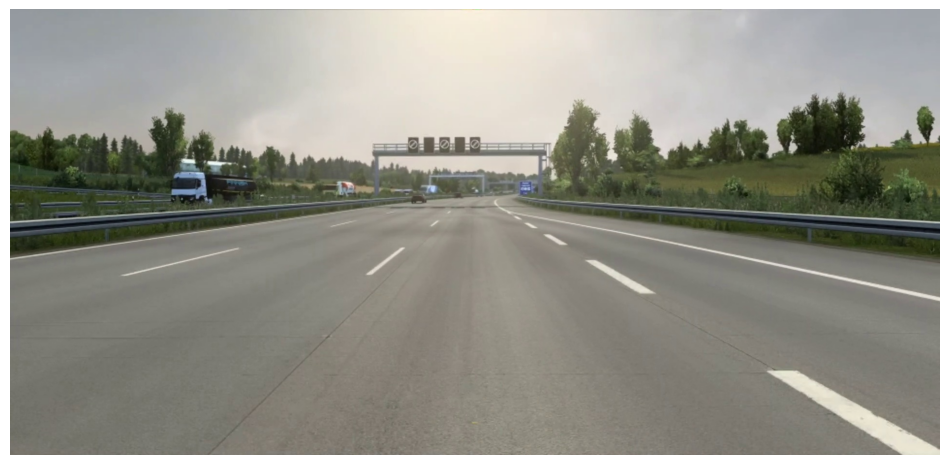

In [26]:
img_name = get_random_cv2_img(example_img_path, True)
img_path = os.path.join(example_img_path, img_name)
img = cv2.imread(img_path)
show(img)


0: 480x960 1 Driveable, 3 Passables, 3 Impassables, 1803.1ms
Speed: 4.6ms preprocess, 1803.1ms inference, 23.3ms postprocess per image at shape (1, 3, 480, 960)


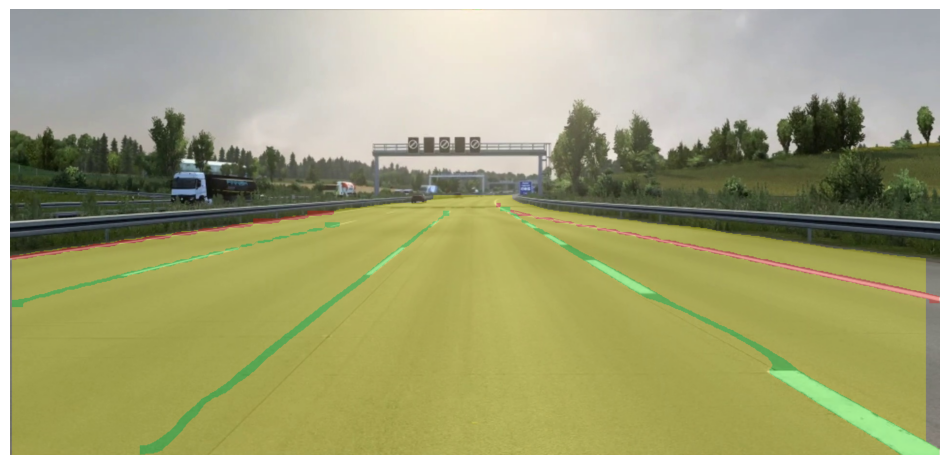

In [27]:
predictions = get_lane_segmentation(img)
segmented_img = draw_segment(img, predictions)

show(segmented_img, cv2_img=True)


0: 480x960 1 Driveable, 3 Passables, 3 Impassables, 1845.4ms
Speed: 3.7ms preprocess, 1845.4ms inference, 30.4ms postprocess per image at shape (1, 3, 480, 960)


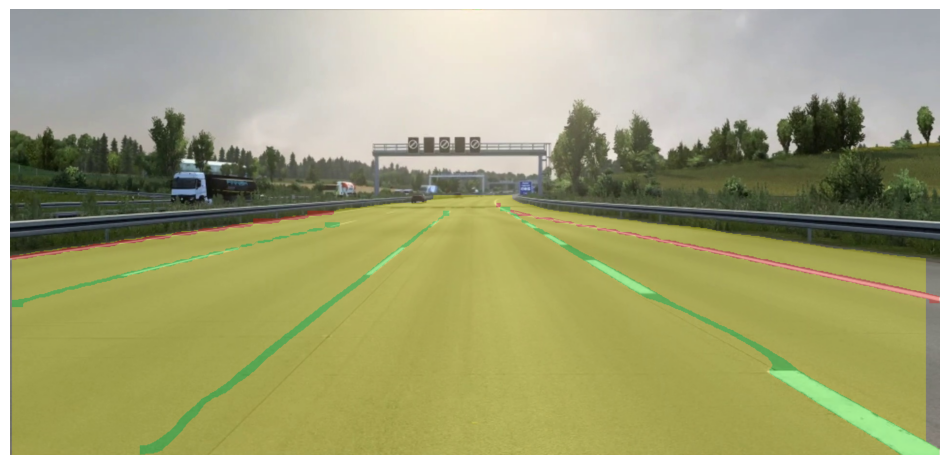

In [28]:
predictions = get_lane_segmentation(img, agnostic_nms=True)
segmented_img = draw_segment(img, predictions)

show(segmented_img, cv2_img=True)


0: 480x960 10 Driveables, 30 Passables, 20 Impassables, 1852.3ms
Speed: 4.1ms preprocess, 1852.3ms inference, 273.9ms postprocess per image at shape (1, 3, 480, 960)


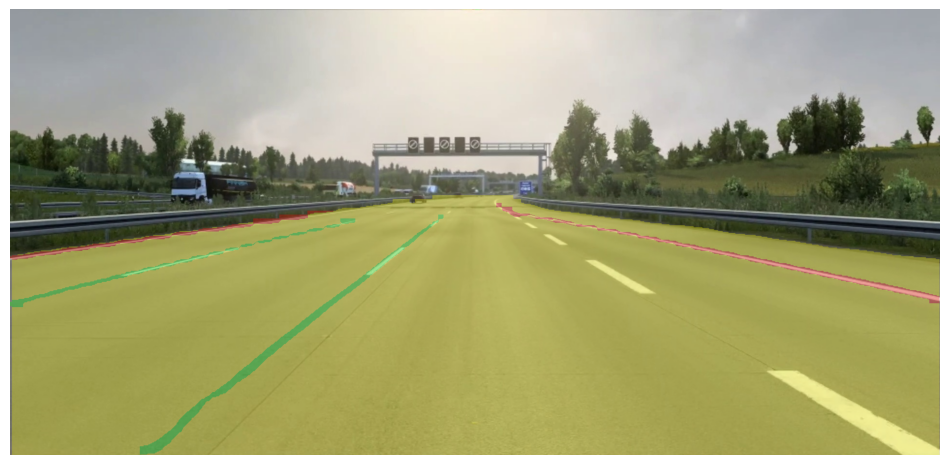

In [29]:
predictions = get_lane_segmentation(img, iou=1.0)
segmented_img = draw_segment(img, predictions)

show(segmented_img, cv2_img=True)


0: 480x960 10 Driveables, 1845.2ms
Speed: 4.3ms preprocess, 1845.2ms inference, 32.7ms postprocess per image at shape (1, 3, 480, 960)


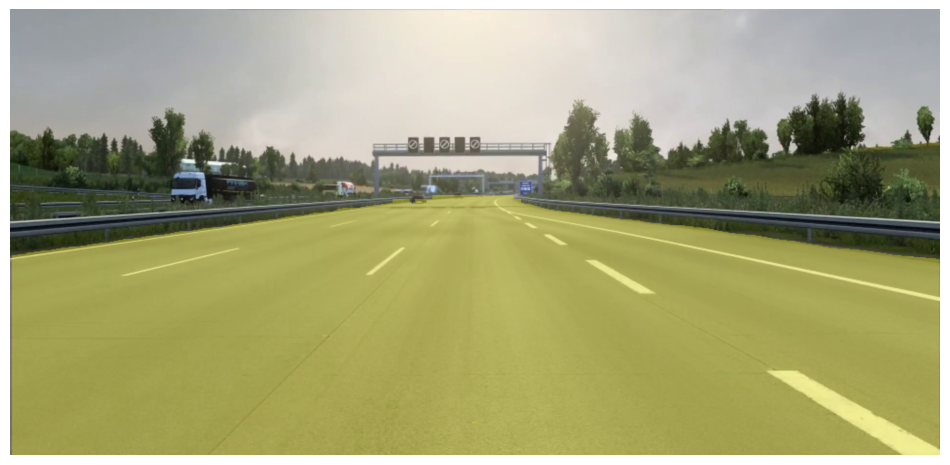

In [30]:
predictions = get_lane_segmentation(img, classes=[0], iou=1.0, agnostic_nms=True)
segmented_img = draw_segment(img, predictions)

show(segmented_img, cv2_img=True)

## Find all available paths

In [287]:
class Segment:
    def __init__(self, poly, cls, conf, img_shape):
        self.poly = poly
        self.cls = cls
        self.conf = conf
        self.img_shape = img_shape
        self.img_height = img_shape[0]
        self.img_width = img_shape[1]

        # use squeeze to removes the middle "1" dimension 
        self.pts = np.squeeze(np.array(poly, dtype=np.int32).reshape((-1, 1, 2)))  
        self.mask = self.mask()

        # if the class is not the driveable class
        if cls != 0:
            # f should be restriced by the y = [0, height]
            self.f = self.approxFunction()

            # approximate points from [height // 2, height] because half the image should be enought to get the lanes for now
            # with [(x, y), ...]
            self.aprox_pts = [(int(self.f(y)), y) for y in range(self.img_height // 2, self.img_height) if 0 <= self.f(y) < self.img_width]
            # get the point where f(height // 4) 
            self.aprox_center_x_pt = int(min(self.aprox_pts, key=lambda pt: abs(pt[1] - int(self.img_height * 0.75)))[0])
            
            # if the lane is left from the center than offset is negative else positive
            self.offset = int(self.aprox_center_x_pt - self.img_width // 2)
            self.abs_offset = abs(self.offset)
            self.is_left = True if self.offset <= 0 else False
            self.is_right = True if self.offset > 0 else False
        else:
            self.f = None
            self.offset = None
            self.abs_offset = None
            self.is_left = None
            self.is_right = None

    # this approximated the lane with a function where x = f(y)
    def approxFunction(self, degree=2):
        # Separate into x, y coordinates
        x_coords = self.pts[:, 0]
        y_coords = self.pts[:, 1]

        coeffs = np.polyfit(y_coords, x_coords, deg=degree)
        f = np.poly1d(coeffs)

        return f

    def mask(self):
        # mask should have only one channel, so a binary img
        mask = np.zeros((self.img_height, self.img_width), dtype=np.uint8)
        cv2.fillPoly(mask, [self.pts], 255)
        
        return mask
        
        

In [44]:
def get_segmentation(img):

    working_img = img.copy()
    working_img = process_image(working_img)
    working_img = cv2.cvtColor(working_img, cv2.COLOR_BGR2RGB)
    
    results = model.predict(working_img, device='cpu', batch=1, conf=0.5)

    predictions = []

    for result in results:
        if result.masks:
            polygons = result.masks.xy
            class_ids = result.boxes.cls.int().tolist()
            confidences = result.boxes.conf.tolist()

            # loop through each predicted segment
            for poly, cls_id, conf in zip(polygons, class_ids, confidences):
                predictions.append(Segment(poly, cls_id, conf, img.shape))

    return predictions

In [134]:
def is_lane_inside_driveable(segment_mask, driveable_mask, threshold=0.5):
    intersection = cv2.bitwise_and(driveable_mask, segment_mask)
    lane_area = cv2.countNonZero(segment_mask)
    overlap_area = cv2.countNonZero(intersection)

    # avoid division by zero
    if lane_area == 0:
        return False  

    percent_inside = overlap_area / lane_area
    return percent_inside >= threshold

In [301]:
def shift_poly_horizontally(f: np.poly1d, n: float) -> np.poly1d:
    coeffs = f.coeffs.copy()
    # The constant term is the last element in coeffs
    coeffs[-1] -= n
    return np.poly1d(coeffs)

In [326]:
def mirror_around_x(f: np.poly1d, x: float) -> np.poly1d:
    coeffs = -f.coeffs.copy()  # negate all coefficients
    coeffs[-1] += 2 * x            # add width to the constant term
    return np.poly1d(coeffs)

Note: For now we calculate paths between lanes and for cases where there are 1 lane. The other cases like only lanes left or right or no lanes are not handelt for now. For that we need to utilize the driveable area and fit a function through that.

In [333]:
import math

def get_paths(predictions):

    driveable = [] # cls == 0
    lanes = [] # cls == 1 or cls == 2

    # 1. sort the segmentations to each type
    for segment in predictions:          
        if segment.cls == 0:
            driveable.append(segment)
        else:
            lanes.append(segment)

    # 2. we need at least one driveable area
    if len(driveable) < 1:
        return None, None

    # 3. only keep the lanes that are at least 50% in the one of the driveable area polygons
    driveable_masks = [d.mask for d in driveable]
    driveable_mask = np.clip(np.sum(driveable_masks, axis=0), 0, 255).astype(np.uint8)
    filtered_lanes = [l for l in lanes if is_lane_inside_driveable(l.mask, driveable_mask)]

    #for l in filtered_lanes:
    #    print(l.aprox_center_x_pt)
    #    show(draw_lane_from_pts(temp_img, l.aprox_pts, (0, 0, 255)))

    # 4. get the minimum impassable lane from the center for left and right side
    #    and if there is no impassable lane on the left or right side, than set the minimum
    #    to infinity
    maxs = [l.offset for l in filtered_lanes if l.is_left and l.cls == 2]
    if len(maxs) > 0:
        closest_impassable_left = max(maxs)
    else:
        closest_impassable_left = -math.inf
    
    mins = [l.offset for l in filtered_lanes if l.is_right and l.cls == 2]
    if len(mins) > 0:
        closest_impassable_right = min(mins)
    else:
        closest_impassable_right = math.inf


    #print(f"Left: {closest_impassable_left}, Right: {closest_impassable_right}")

    # 5. only keep the left/right lanes that are closer or equal to the center than the closest impassable lane
    #    (so if threre is no impassable lane on that side than keeep all lanes of that side)
    
    striped_lanes = []
    for l in filtered_lanes:
        if closest_impassable_left <= l.offset <= closest_impassable_right:
            striped_lanes.append(l)
    
    # 6. sort the lanes by there offset values from left to right, so smallest to biggest x
    sorted_lanes = sorted(striped_lanes, key=lambda l: l.offset)

    # 7. from left to right: calculate a non-linear function that descripts the center of both lanes
    paths = []
    for i in range(len(sorted_lanes) - 1):
        paths.append((sorted_lanes[i].f + sorted_lanes[i + 1].f) / 2)

    # 8. check for only one lane

    if len(sorted_lanes) == 1:
        l = sorted_lanes[0]
        if l.is_left:
            h = mirror_around_x(l.f, l.img_width // 2)
            g = (l.f + h) / 2
        else:
            h = mirror_around_x(l.f, -l.img_width // 2)
            g = (l.f + h) / 2
            
        # check if the new path is in the driveable area
        pts = [(int(g(y)), y) for y in range(l.img_height // 2, l.img_height) if 0 <= g(y) < l.img_width]
        pts = np.array(pts, dtype=np.int32)
        pts = pts.reshape((-1, 1, 2))
        g_mask = np.zeros((l.img_height, l.img_width), dtype=np.uint8)
        cv2.fillPoly(g_mask, [pts], 255)
        if is_lane_inside_driveable(g_mask, driveable_mask):
            paths.append(g)

    if len(sorted_lanes) == 0:
        paths = None

    # 9. return the driveable paths
    return paths

In [285]:
def draw_lane_from_pts(img, pts, color, alpha=0.4):
    working_img = img.copy()

    pts_np = np.array(pts, dtype=np.int32)   # convert list to np.array
    pts_np = pts_np.reshape((-1, 1, 2))      # reshape to OpenCV format
    
    cv2.polylines(working_img, [pts_np], isClosed=False, color=color, thickness=5)

    y = int(img.shape[0] * 0.75)
    cv2.line(working_img, (0, y), (img.shape[1] - 1, y), (255, 0, 255), thickness=4)

    return working_img

In [160]:
def draw_lane(img, polygons, color, alpha=0.4):
    working_img = img.copy()
    overlay = img.copy()

    for poly in polygons:
        # convert shapely polygon to OpenCV format
        pts = np.array(poly, dtype=np.int32).reshape((-1, 1, 2))
        cv2.fillLine(overlay, [pts], color=color)

    # Blend overlay onto original image
    cv2.addWeighted(overlay, alpha, working_img, 1 - alpha, 0, dst=working_img)

    return working_img

In [249]:
def show_paths(img):
    GREEN = (0, 255, 0)
    RED = (0, 0, 255)
    
    predictions = get_segmentation(img)
    paths = get_paths(predictions)
    
    output_img = img.copy()
    
    for p in paths:    
        pts = [(int(p(y)), y) for y in range(img.shape[0] // 2, img.shape[0]) if 0 <= p(y) < img.shape[1]]
        pts_np = np.array(pts, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(output_img, [pts_np], isClosed=False, color=(139, 0, 0), thickness=5)
    
    
    show(output_img)


0: 480x960 1 Driveable, 1 Passable, 2 Impassables, 1585.2ms
Speed: 3.8ms preprocess, 1585.2ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 960)


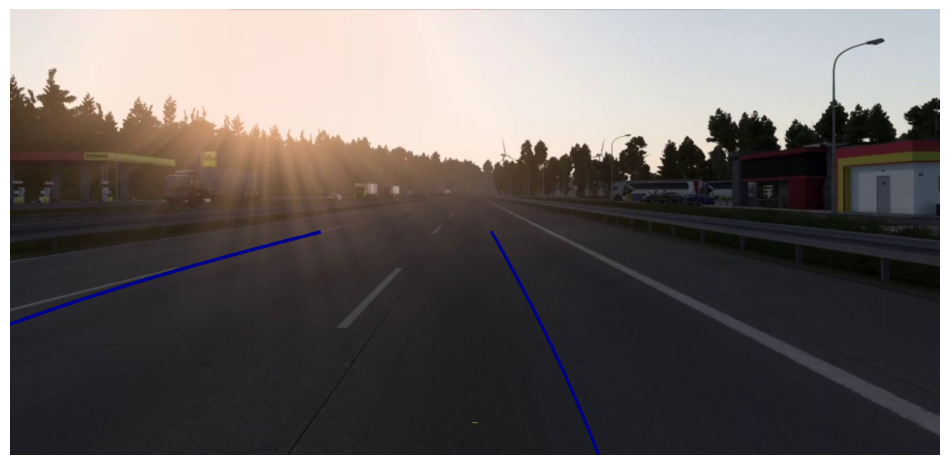

In [253]:
temp_img = cv2.imread(os.path.join(example_img_path, get_random_cv2_img(example_img_path, True)))
show_paths(temp_img)


0: 480x960 1 Driveable, 1 Passable, 2 Impassables, 1586.4ms
Speed: 4.2ms preprocess, 1586.4ms inference, 15.5ms postprocess per image at shape (1, 3, 480, 960)


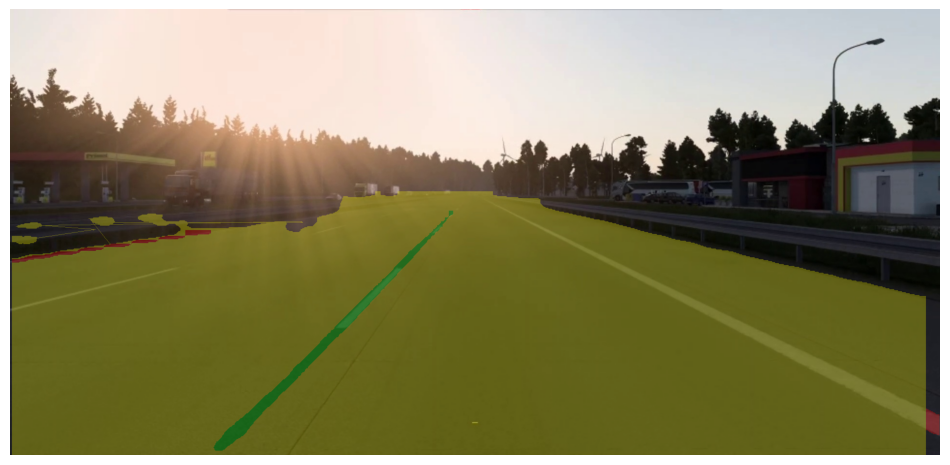

In [255]:
predictions = get_lane_segmentation(temp_img)
segmented_img = draw_segment(temp_img, predictions)

show(segmented_img, cv2_img=True)

In [ ]:
temp_img = cv2.imread(os.path.join(example_img_path, get_random_cv2_img(example_img_path, True)))

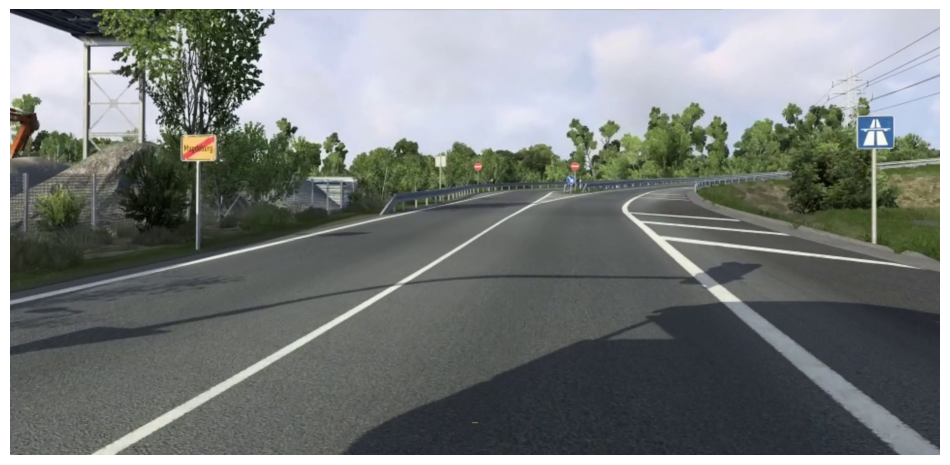

In [274]:
show(temp_img)


0: 480x960 1 Driveable, 4 Impassables, 1613.3ms
Speed: 4.9ms preprocess, 1613.3ms inference, 17.4ms postprocess per image at shape (1, 3, 480, 960)


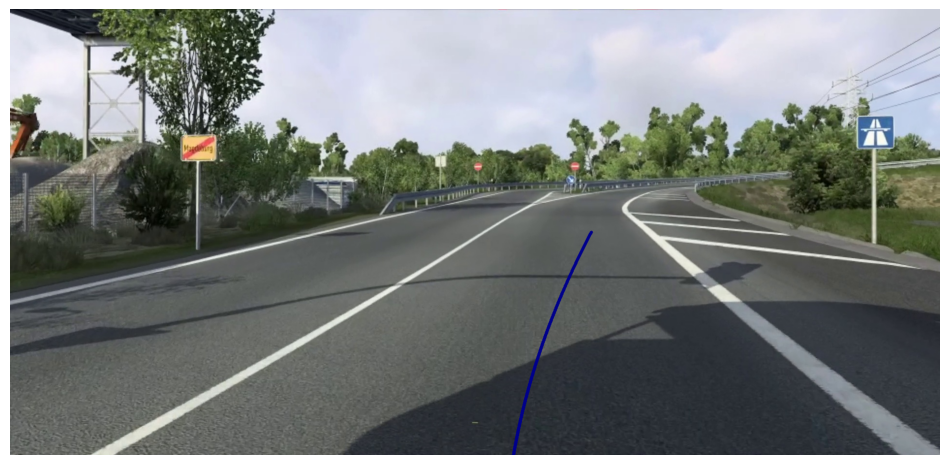

In [290]:
show_paths(temp_img)

In [ ]:
temp_img = cv2.imread(os.path.join(example_img_path, get_random_cv2_img(example_img_path, True)))

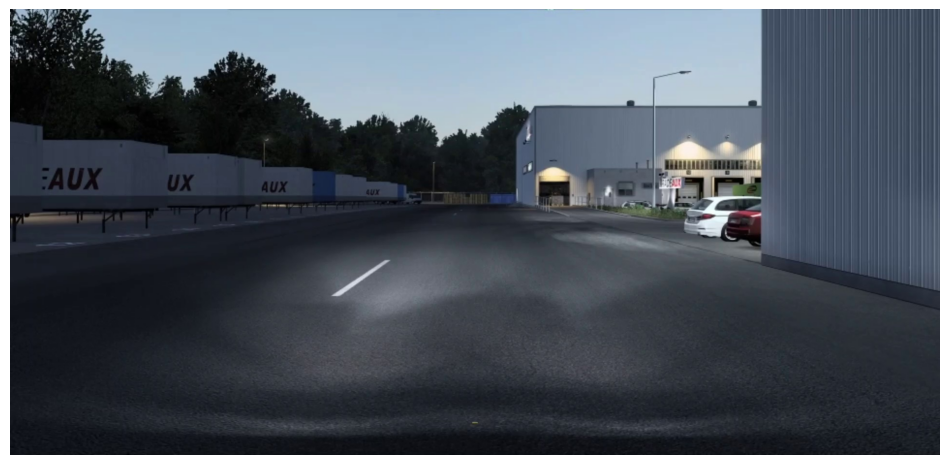

In [316]:
show(temp_img)


0: 480x960 1 Driveable, 1 Passable, 1668.3ms
Speed: 6.5ms preprocess, 1668.3ms inference, 9.2ms postprocess per image at shape (1, 3, 480, 960)


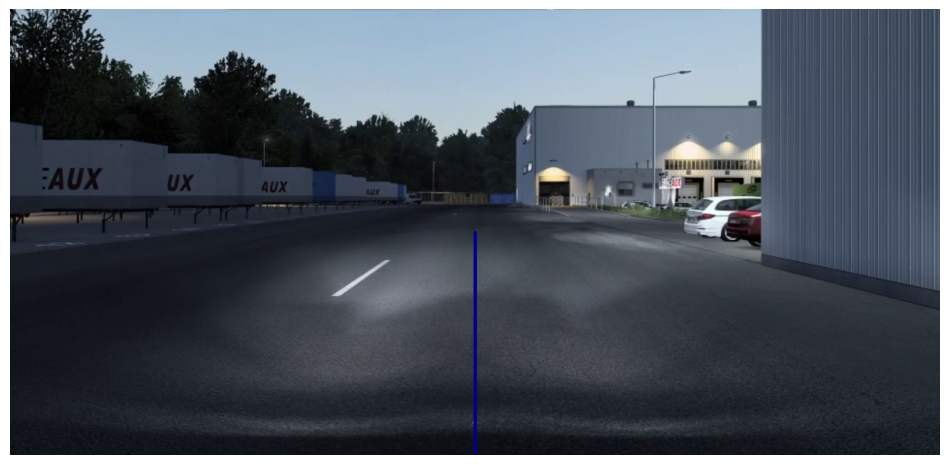

In [334]:
show_paths(temp_img)


0: 480x960 1 Driveable, 4 Impassables, 1598.3ms
Speed: 4.5ms preprocess, 1598.3ms inference, 17.7ms postprocess per image at shape (1, 3, 480, 960)


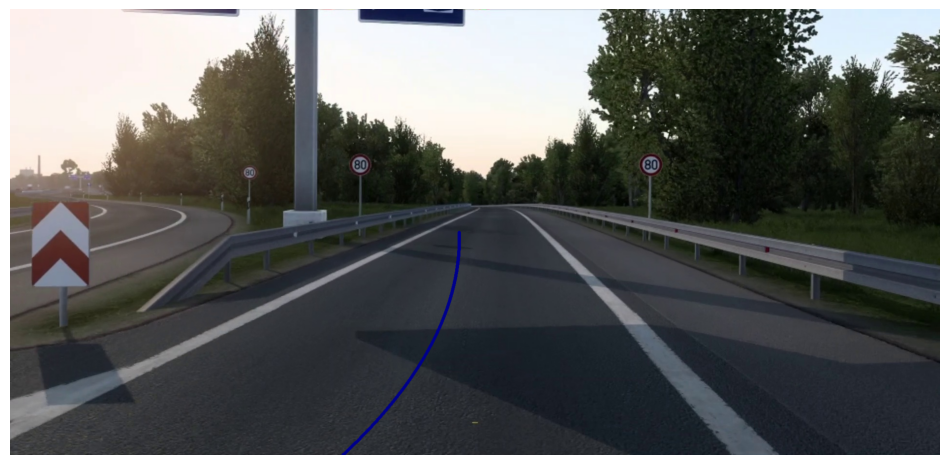

In [335]:
temp_img = cv2.imread(os.path.join(example_img_path, get_random_cv2_img(example_img_path, True)))
show_paths(temp_img)


0: 480x960 1 Driveable, 3 Impassables, 1727.5ms
Speed: 6.0ms preprocess, 1727.5ms inference, 16.0ms postprocess per image at shape (1, 3, 480, 960)


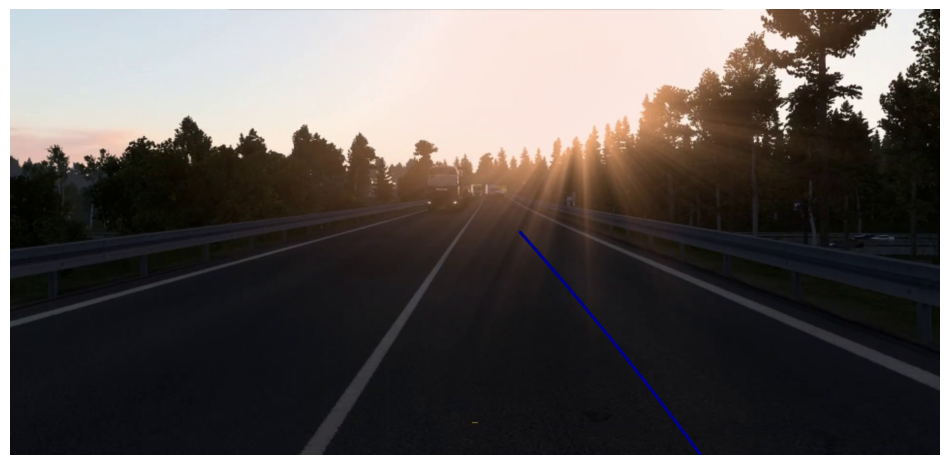

In [336]:
temp_img = cv2.imread(os.path.join(example_img_path, get_random_cv2_img(example_img_path, True)))
show_paths(temp_img)


0: 480x960 1 Driveable, 1 Passable, 1636.0ms
Speed: 4.1ms preprocess, 1636.0ms inference, 10.3ms postprocess per image at shape (1, 3, 480, 960)


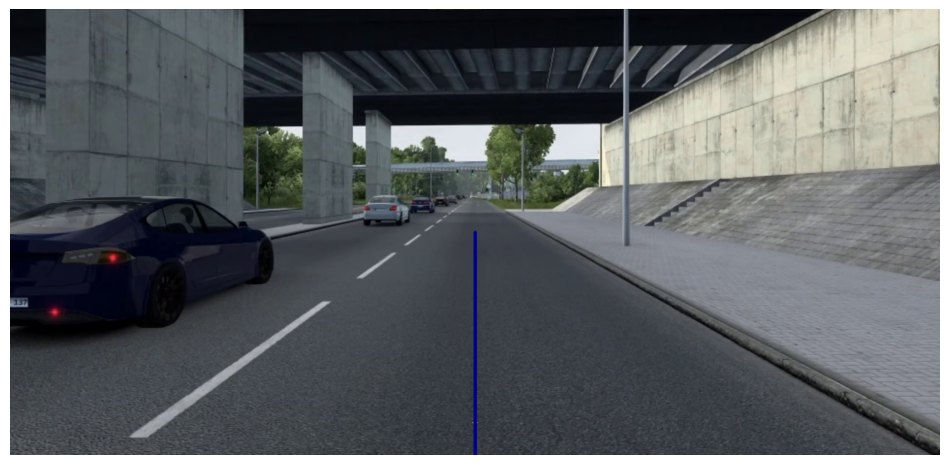

In [337]:
temp_img = cv2.imread(os.path.join(example_img_path, get_random_cv2_img(example_img_path, True)))
show_paths(temp_img)


0: 480x960 1 Driveable, 2 Passables, 2 Impassables, 1643.5ms
Speed: 4.6ms preprocess, 1643.5ms inference, 18.4ms postprocess per image at shape (1, 3, 480, 960)


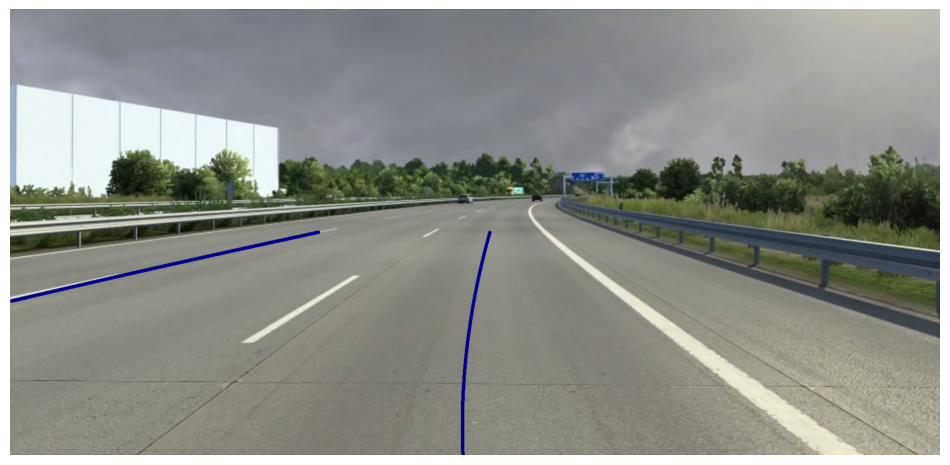

In [338]:
temp_img = cv2.imread(os.path.join(example_img_path, get_random_cv2_img(example_img_path, True)))
show_paths(temp_img)

Conculsion: Seeing this, the basic cases work well. The problem may be that there are again a lot of cases where the current path calculation must be adjusted. Also the Network must be trained more percice and maybe it would be better to train the driveable area, the lanes and maybe the driveable paths on there one network each and than combine all informations to get a robust final output path, so a mix of calculation and predictions. For now driving on highway should work in most of the cases.